# The Flowers Dataset

$\textbf{About the Dataset}$

 The dataset contains 3670 raw jpeg images of five types of flowers:
- daisy
- dandelion
- rose
- sunflower
- tulip


In the associated folder one will find five folders namely - 'daisy', 'dandelion', 'rose', 'sunflower' and 'tulip' which contain the images of the respective flowers. In this notebook our goal will be to build a neural network from scratch, and then finetune it to improve the model.

In [1]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras
from matplotlib import pyplot as plt
import zipfile
from shutil import copyfile
from time import time
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import numpy as np
import random as python_random
from tensorflow.keras.applications import VGG16
from keras import layers, models
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import drive
import tarfile
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
import seaborn as sns
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Exploring the dataset

We start by loading the data from our Drive folder:

In [2]:
drive.mount('/content/gdrive')
# Path to your .tgz file
file_path = 'gdrive/My Drive/Colab Notebooks/flower_photos.tgz'

# Extract the contents
with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall('/content/')

Mounted at /content/gdrive


In [3]:
batch_size = 32
img_height = 224
img_width = 224

def load_data(folder_path):
    X = []
    y = []
    class_names = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    print("Class names:", class_names)

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(folder_path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                image = load_img(image_path, target_size=(224, 224)) # change image size from original to make them of same shape
                image = img_to_array(image)
                X.append(image)
                y.append(i)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
    X = np.array(X)
    y = np.array(y)
    return X, y, class_names

# Load the data
X, y, class_names = load_data('flower_photos')

Class names: ['tulips', 'sunflowers', 'roses', 'daisy', 'dandelion']


See the distribution of images sizes:

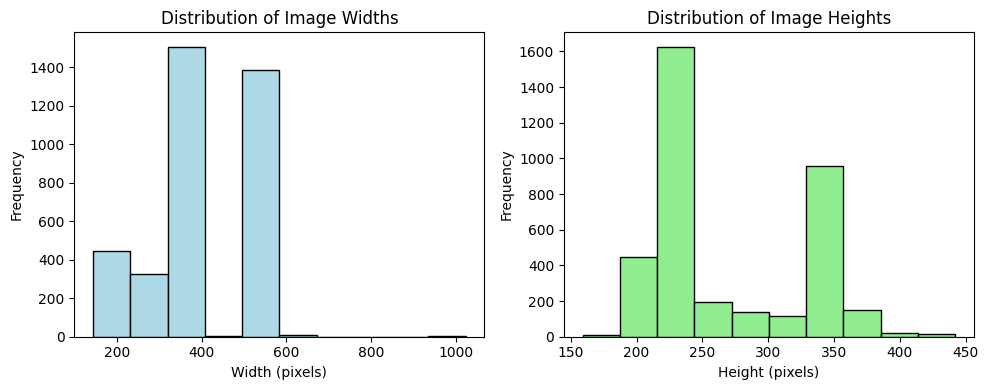

In [4]:

# Function to get image sizes
def get_image_sizes(folder_path):
    widths = []
    heights = []
    class_names = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]

    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                with Image.open(image_path) as img:
                    width, height = img.size
                    widths.append(width)
                    heights.append(height)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")

    return widths, heights

# Get image sizes
widths, heights = get_image_sizes('flower_photos')

# Visualize the distribution of image sizes
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=10, color='lightblue', edgecolor='black')
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=10, color='lightgreen', edgecolor='black')
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Checking the image sizes before resizing them to a standard size like 224x224 pixels can be important for several reasons:

1) Data Quality Assessment:

- Anomalies: Detecting images that may have unusual dimensions (e.g., extremely small or large images) can indicate potential data quality issues.
- Consistency: Ensuring that the majority of images are within a reasonable range of sizes can confirm the dataset's overall consistency.

2) Aspect Ratio Preservation:

- Distortion: If images have widely varying aspect ratios, resizing them to a fixed size can distort the images, which may affect model performance. Understanding the aspect ratios can help you decide whether to crop or pad images to maintain aspect ratios.
Resource Planning:

- Memory Usage: Larger images consume more memory and computational resources. Knowing the distribution of image sizes can help in planning the computational resources needed for processing and training.
Preprocessing Strategy:

- Informed Decisions: Insights from the size distribution can guide decisions on preprocessing techniques, such as whether to use resizing, cropping, padding, or other transformations.

Let's see how the classes are distributed:

Labels distribution:
Class: tulips , Count: 799 , Perc :21.8%
Class: sunflowers , Count: 699 , Perc :19.0%
Class: roses , Count: 641 , Perc :17.5%
Class: daisy , Count: 633 , Perc :17.2%
Class: dandelion , Count: 898 , Perc :24.5%


<ipython-input-5-6c79791ebbdc>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_classes, y=class_counts, palette=palette)


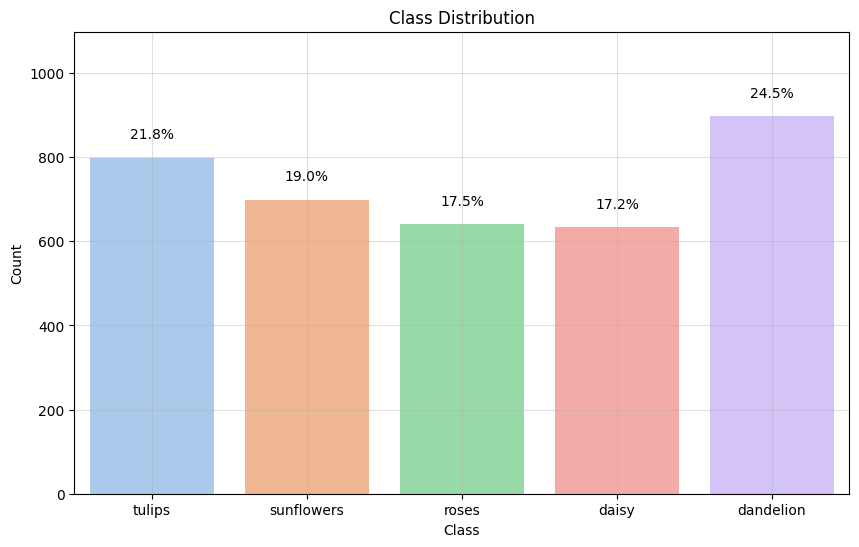

In [5]:
# Data exploration
unique_classes, class_counts = np.unique(y, return_counts=True)

print('Labels distribution:')
for i in range(5):
    print('Class:', class_names[i], ', Count:', class_counts[i], ', Perc :{:.1f}%'.format(100*class_counts[i]/len(y)))

palette = sns.color_palette("pastel", len(unique_classes))

plt.figure(figsize=(10, 6))
sns.barplot(x=unique_classes, y=class_counts, palette=palette)

for i, count in enumerate(class_counts):
    percentage = 100 * count / len(y)
    plt.text(i, count + 0.05 * max(class_counts), f'{percentage:.1f}%', ha='center')

plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(unique_classes, class_names)
plt.grid(True, alpha=0.4)
plt.ylim(0, max(class_counts) + 200)  # Adjusting y-axis limit to add some space for annotations

#plt.savefig("classes-distribution.png")
#files.download("classes-distribution.png")
plt.show()

We see they are almost evenly distributed, so we will first try to train the neural network without data augmentation. Then, we will augment the data and see if this helps in improving the model.

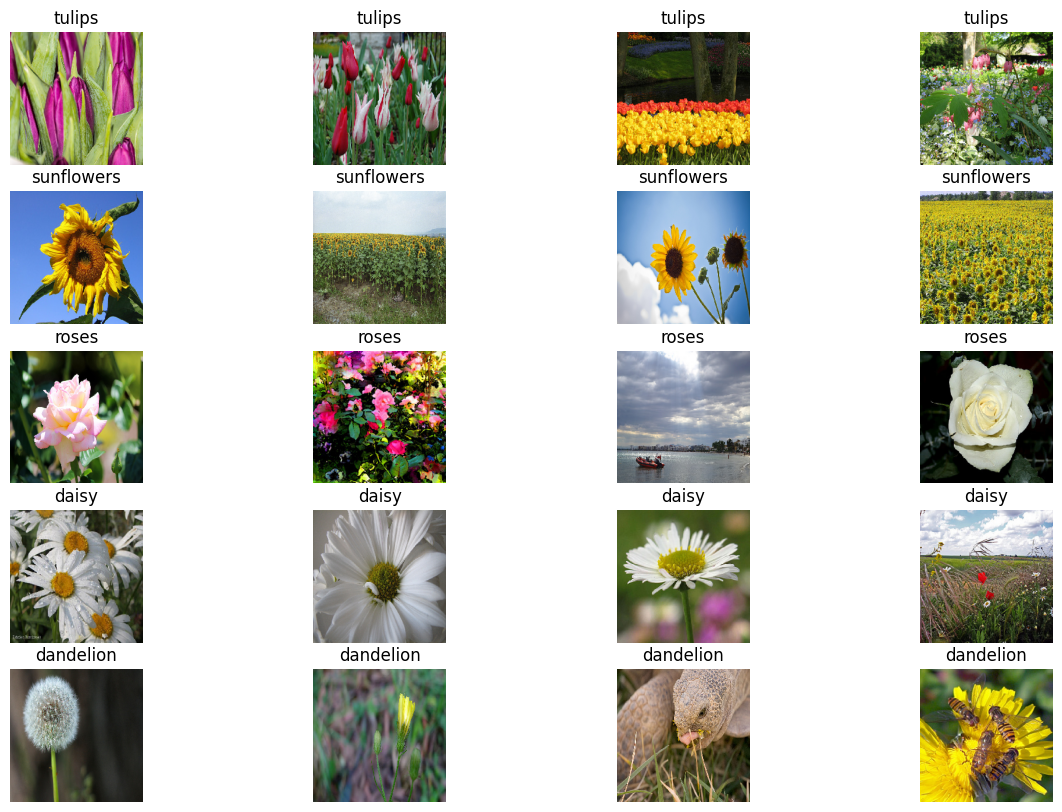

In [6]:
# Function to display sample images

def display_sample_images(X, y, class_names, samples_per_class=4):
    plt.figure(figsize=(15, 10))
    for cls_idx, class_name in enumerate(class_names):
        idxs = np.where(y == cls_idx)[0]
        selected_idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(selected_idxs):
            plt.subplot(len(class_names), samples_per_class, cls_idx * samples_per_class + i + 1)
            plt.imshow(X[idx].astype("uint8"))
            plt.title(class_name)
            plt.axis('off')
    plt.show()

# Display few samples
display_sample_images(X, y, class_names)

# Preprocessing

We normalize the dataset, and provide the augmentation using the module $\texttt{keras.layers.experimental.preprocessing}$.

In [7]:
def split_data(X, y, train_size, val_size, test_size, random_state=None):

    if train_size + val_size + test_size != 1.0:
        raise ValueError("The sum of train_size, val_size, and test_size must be 1.0")

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(val_size + test_size), random_state=random_state)
    remaining_proportion = val_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(1 - remaining_proportion), random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

Normalizing image data by dividing by 255 is a common practice because pixel values in typical images are represented as integers in the range [0, 255]. This range corresponds to an 8-bit representation of pixel intensities, where 0 represents black and 255 represents white in grayscale images.

In [8]:
# Normalize data first:

X_normalized = X/255.

In [9]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_normalized, y,
                                                            train_size=0.8,
                                                            val_size=0.1,
                                                            test_size=0.1,
                                                            random_state=42)

In [10]:
# Delete unused data, to prevent RAM from going boom

del(X)
del(X_normalized)

In [11]:
# Check classes percentages

unique_classes_train, class_counts_train = np.unique(y_train, return_counts=True)
unique_classes_val, class_counts_val = np.unique(y_val, return_counts=True)
unique_classes_test, class_counts_test = np.unique(y_test, return_counts=True)

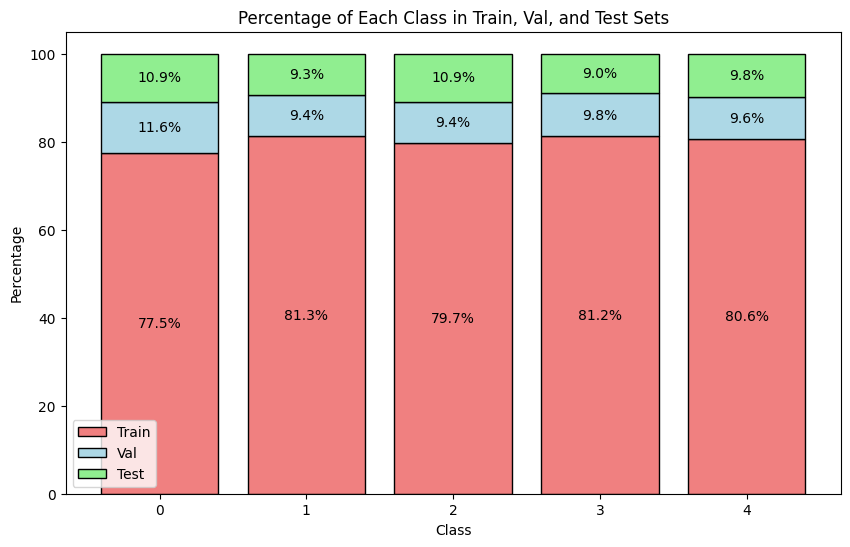

In [12]:
# Calculate the total counts for each class across all sets
total_counts_per_class = class_counts_train + class_counts_val + class_counts_test

# Normalize the counts to percentages for each class
percent_train = (class_counts_train / total_counts_per_class) * 100
percent_val = (class_counts_val / total_counts_per_class) * 100
percent_test = (class_counts_test / total_counts_per_class) * 100

plt.figure(figsize=(10, 6))

# Create the initial bar for the training and validation set
bars_train = plt.bar(unique_classes, percent_train, edgecolor='black', color='lightcoral', label='Train')
bars_val = plt.bar(unique_classes, percent_val, bottom=percent_train, edgecolor='black', color='lightblue', label='Val')

# Calculate the cumulative percentages for the training and validation sets
cumulative_percent = percent_train + percent_val
bars_test = plt.bar(unique_classes, percent_test, bottom=cumulative_percent, edgecolor='black', color='lightgreen', label='Test')

# Add text labels to the bars
for bar in bars_train:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height / 2.0, f'{height:.1f}%', ha='center', va='center', color='black')

for bar, bottom in zip(bars_val, percent_train):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, bottom + height / 2.0, f'{height:.1f}%', ha='center', va='center', color='black')

for bar, bottom in zip(bars_test, cumulative_percent):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, bottom + height / 2.0, f'{height:.1f}%', ha='center', va='center', color='black')

plt.title('Percentage of Each Class in Train, Val, and Test Sets')
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.xticks(unique_classes)
plt.legend()
#plt.savefig("SPLIT-distribution.png")
#files.download("SPLIT-distribution.png")
plt.show()

In [ ]:
# Sequence of modules to place before the actual NN

data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip('horizontal',input_shape = (224,224,3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),
    keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

# Neural Network

## Without data augmentation

In [ ]:
model = keras.models.Sequential([

    keras.layers.Input(shape=(224, 224, 3)),

    keras.layers.Conv2D(filters = 16,kernel_size = (3,3) , activation = 'relu',padding = 'same'),
    keras.layers.MaxPool2D((3,3)),
    keras.layers.Conv2D(filters = 32,kernel_size = (3,3) , activation = 'relu'),
    keras.layers.MaxPool2D((3,3)),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(filters = 64,kernel_size = (3,3) , activation = 'relu',padding = 'same'),
    keras.layers.MaxPool2D((3,3)),
    keras.layers.Conv2D(filters = 128,kernel_size = (3,3) , activation = 'relu',padding = 'same'),
    keras.layers.MaxPool2D((3,3)),
    keras.layers.Dropout(0.2),

    keras.layers.Flatten(),
    keras.layers.Dense(64,activation = 'relu'),
    keras.layers.Dense(32,activation = 'relu'),
    keras.layers.Dense(5,activation = 'softmax')
])

In [ ]:
# for the moment fix LR and epochs

lr = 0.001
epochs = 30
n_classes = 5

In [ ]:
# Compile the model
optimizer = Adam(learning_rate=lr)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)       

In [ ]:
# Encode classes in valid format

y_train_encoded = to_categorical(y_train, n_classes)
y_val_encoded = to_categorical(y_val, n_classes)

# Include if you want to stop when not improving anymore
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [ ]:
# Fit the model

history = model.fit(
    x=X_train,
    y=y_train_encoded,
    epochs=epochs,
    validation_data=(X_val, y_val_encoded),
    #callbacks=[early_stopping],
    batch_size=batch_size,
    #class_weight=class_weight_dict
)

Epoch 1/30
92/92 [==============================] - 12s 72ms/step - loss: 1.4193 - accuracy: 0.3614 - val_loss: 1.1365 - val_accuracy: 0.5041
Epoch 2/30
92/92 [==============================] - 4s 48ms/step - loss: 1.1018 - accuracy: 0.5405 - val_loss: 1.0273 - val_accuracy: 0.5831
Epoch 3/30
92/92 [==============================] - 4s 41ms/step - loss: 0.9766 - accuracy: 0.6005 - val_loss: 0.9934 - val_accuracy: 0.5368
Epoch 4/30
92/92 [==============================] - 4s 45ms/step - loss: 0.9044 - accuracy: 0.6158 - val_loss: 0.9291 - val_accuracy: 0.6131
Epoch 5/30
92/92 [==============================] - 4s 47ms/step - loss: 0.8255 - accuracy: 0.6614 - val_loss: 0.8552 - val_accuracy: 0.6594
Epoch 6/30
92/92 [==============================] - 3s 33ms/step - loss: 0.7832 - accuracy: 0.6812 - val_loss: 0.8220 - val_accuracy: 0.6512
Epoch 7/30
92/92 [==============================] - 3s 30ms/step - loss: 0.7574 - accuracy: 0.7040 - val_loss: 0.8328 - val_accuracy: 0.6730
Epoch 8/30
9

In [ ]:
# Save the model to Google Drive
drive.mount('/content/gdrive')

model_save_path = 'gdrive/My Drive/Colab Notebooks/flower_classification_NOAUG_model.h5'
model.save(model_save_path)

# Load the model from Google Drive
model_load_path = 'gdrive/My Drive/Colab Notebooks/flower_classification_NOAUG_model.h5'
loaded_model = tf.keras.models.load_model(model_load_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## With data augmentation

In [ ]:
model_aug = keras.models.Sequential([

    data_augmentation, # insert prior to any operation

    keras.layers.Conv2D(filters = 16,kernel_size = (3,3) , activation = 'relu',padding = 'same'),
    keras.layers.MaxPool2D((3,3)),
    keras.layers.Conv2D(filters = 32,kernel_size = (3,3) , activation = 'relu'),
    keras.layers.MaxPool2D((3,3)),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(filters = 64,kernel_size = (3,3) , activation = 'relu',padding = 'same'),
    keras.layers.MaxPool2D((3,3)),
    keras.layers.Conv2D(filters = 128,kernel_size = (3,3) , activation = 'relu',padding = 'same'),
    keras.layers.MaxPool2D((3,3)),
    keras.layers.Dropout(0.2),

    keras.layers.Flatten(),
    keras.layers.Dense(64,activation = 'relu'),
    keras.layers.Dense(32,activation = 'relu'),
    keras.layers.Dense(5,activation = 'softmax')
])

In [ ]:
# Compile the model
optimizer = Adam(learning_rate=lr)

model_aug.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
# Print model summary
model_aug.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 24, 24, 32)       

In [ ]:
# Fit the model

history_aug = model_aug.fit(
    x=X_train,
    y=y_train_encoded,
    epochs=epochs,
    validation_data=(X_val, y_val_encoded),
    #callbacks=[early_stopping],
    batch_size=batch_size,
    #class_weight=class_weight_dict
)

Epoch 1/30
92/92 [==============================] - 10s 56ms/step - loss: 1.3527 - accuracy: 0.3917 - val_loss: 1.1468 - val_accuracy: 0.4741
Epoch 2/30
92/92 [==============================] - 4s 46ms/step - loss: 1.1290 - accuracy: 0.5143 - val_loss: 1.0166 - val_accuracy: 0.6104
Epoch 3/30
92/92 [==============================] - 4s 43ms/step - loss: 1.0546 - accuracy: 0.5596 - val_loss: 1.0005 - val_accuracy: 0.5777
Epoch 4/30
92/92 [==============================] - 3s 34ms/step - loss: 0.9846 - accuracy: 0.5950 - val_loss: 0.8900 - val_accuracy: 0.6213
Epoch 5/30
92/92 [==============================] - 3s 35ms/step - loss: 0.9237 - accuracy: 0.6202 - val_loss: 0.8515 - val_accuracy: 0.6730
Epoch 6/30
92/92 [==============================] - 3s 35ms/step - loss: 0.8876 - accuracy: 0.6431 - val_loss: 0.8041 - val_accuracy: 0.6322
Epoch 7/30
92/92 [==============================] - 4s 45ms/step - loss: 0.8662 - accuracy: 0.6454 - val_loss: 0.9135 - val_accuracy: 0.6294
Epoch 8/30
9

In [ ]:
# Save the model to Google Drive
drive.mount('/content/gdrive')

model_save_path = 'gdrive/My Drive/Colab Notebooks/flower_classification_AUG_model.h5'
model_aug.save(model_save_path)

# Load the model from Google Drive
model_load_path = 'gdrive/My Drive/Colab Notebooks/flower_classification_AUG_model.h5'
loaded_model_aug = tf.keras.models.load_model(model_load_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# History results

## Without data augmentation

In [ ]:
y_test_encoded = to_categorical(y_test, n_classes)

In [ ]:
#test set performance
print(model.evaluate(X_test, y_test_encoded))

12/12 [==============================] - 0s 17ms/step - loss: 0.9451 - accuracy: 0.7711
[0.9450795650482178, 0.7711171507835388]


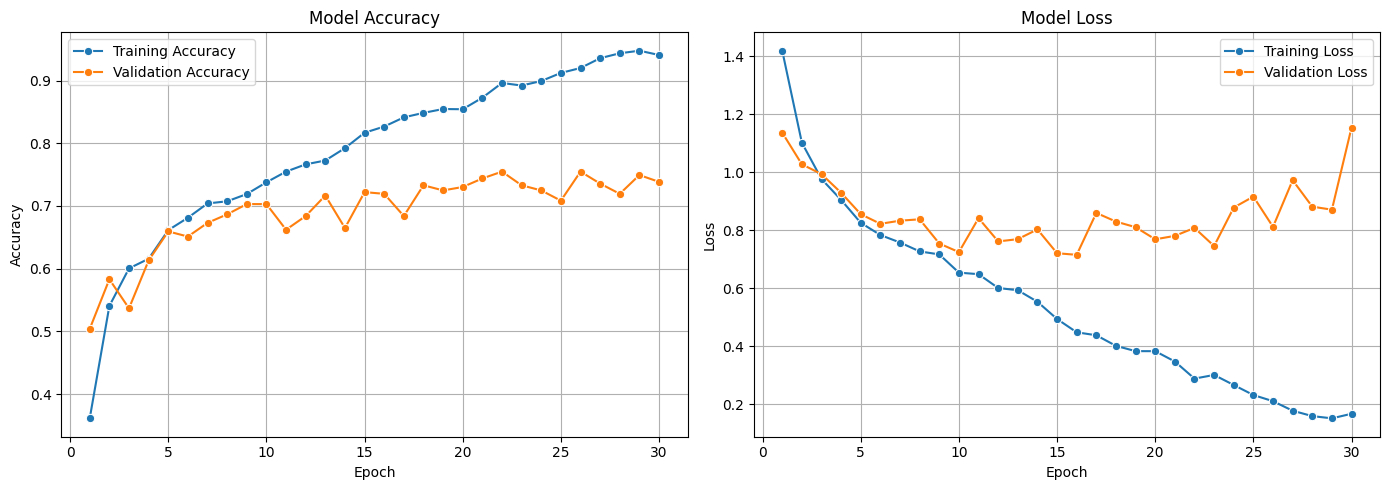

In [ ]:
# Assuming you have the history dictionary loaded
history_dict = history.history

# Create a DataFrame from the history dictionary
history_df = pd.DataFrame(history_dict)

# Add an epoch column
history_df['epoch'] = history_df.index + 1

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df, x='epoch', y='accuracy', label='Training Accuracy', marker='o')
sns.lineplot(data=history_df, x='epoch', y='val_accuracy', label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
sns.lineplot(data=history_df, x='epoch', y='loss', label='Training Loss', marker='o')
sns.lineplot(data=history_df, x='epoch', y='val_loss', label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
#plt.savefig("accuracy-withoutAUG.png")
#files.download("accuracy-withoutAUG.png")
plt.show()

## With data augmentation

In [ ]:
#test set performance
print(model_aug.evaluate(X_test, y_test_encoded))

12/12 [==============================] - 0s 15ms/step - loss: 0.5802 - accuracy: 0.7875
[0.5802362561225891, 0.7874659299850464]


In [ ]:
y_pred = model_aug.predict(X_test)
print(y_pred.shape)

12/12 [==============================] - 0s 19ms/step
(367, 5)


In [ ]:
#f1 score
from sklearn.metrics import f1_score

y_pred_classes = np.argmax(y_pred, axis=1)

f1_per_class = f1_score(y_test, y_pred_classes, average=None)
for i, f1 in enumerate(f1_per_class):
    print(f"F1 Score for class {i}: {f1}")

print("Weighted f1: ",f1_score(y_test, y_pred_classes, average="weighted"))

F1 Score for class 0: 0.7261904761904762
F1 Score for class 1: 0.8108108108108109
F1 Score for class 2: 0.6611570247933886
F1 Score for class 3: 0.8658536585365854
F1 Score for class 4: 0.8470588235294119
Weighted f1:  0.7824794676113841


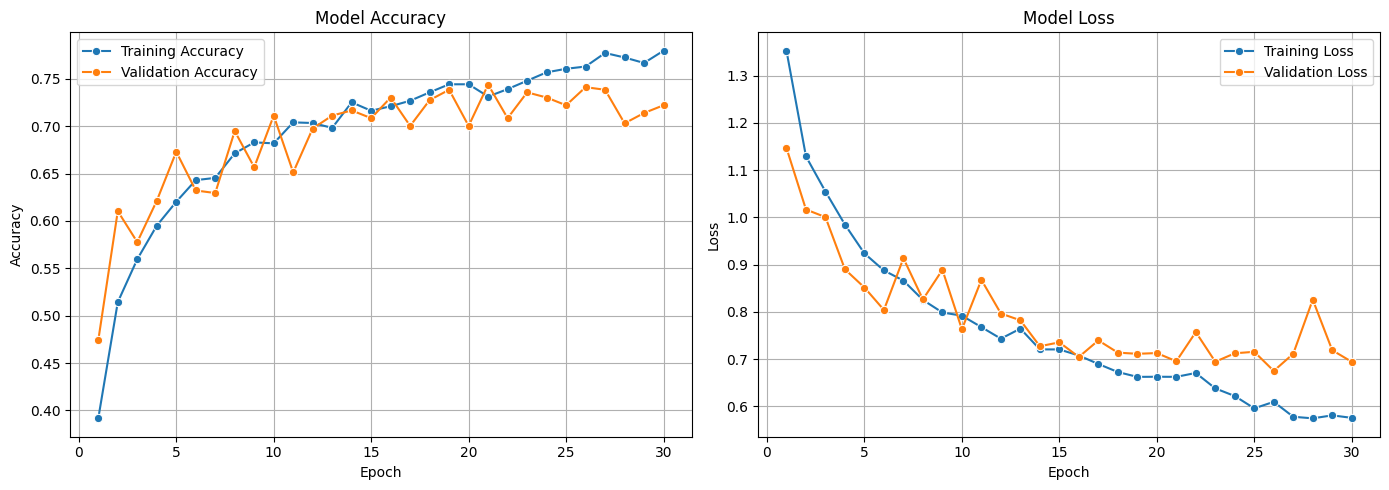

In [ ]:
# Assuming you have the history dictionary loaded
history_dict_aug = history_aug.history

# Create a DataFrame from the history dictionary
history_df_aug = pd.DataFrame(history_dict_aug)

# Add an epoch column
history_df_aug['epoch'] = history_df_aug.index + 1

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df_aug, x='epoch', y='accuracy', label='Training Accuracy', marker='o')
sns.lineplot(data=history_df_aug, x='epoch', y='val_accuracy', label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
sns.lineplot(data=history_df_aug, x='epoch', y='loss', label='Training Loss', marker='o')
sns.lineplot(data=history_df_aug, x='epoch', y='val_loss', label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
#plt.savefig("accuracy-withAUG.png")
#files.download("accuracy-withAUG.png")
plt.show()

12/12 [==============================] - 0s 12ms/step
Confusion Matrix:
[[61  6 12  3  5]
 [ 2 45  1  5  4]
 [15  1 40  4  8]
 [ 2  1  0 71  7]
 [ 1  1  0  0 72]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

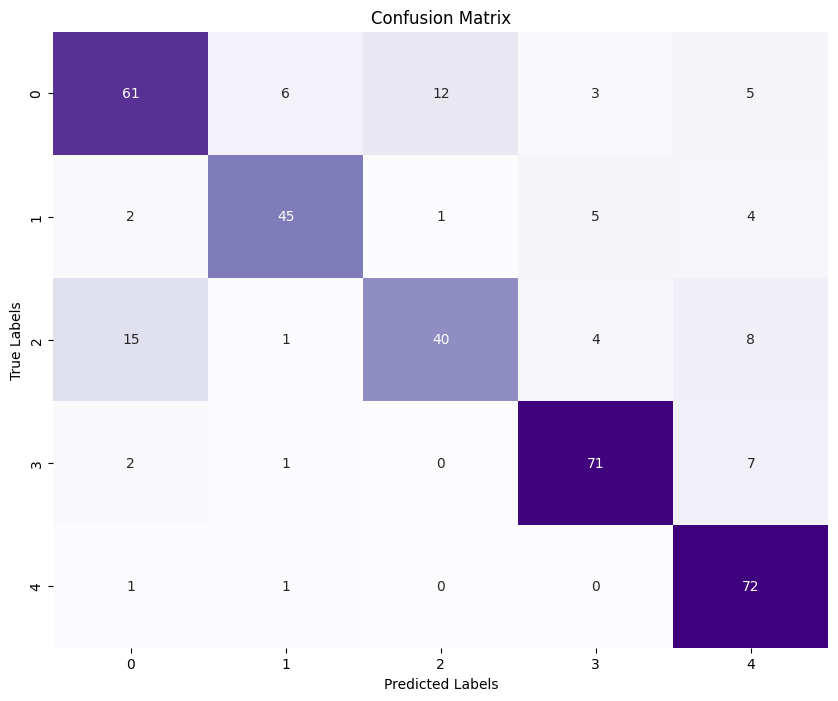

In [ ]:
y_pred_aug = loaded_model_aug.predict(X_test)

# Convert probabilities to class labels
y_pred_classes_aug = np.argmax(y_pred_aug, axis=1)

# Now you can compute the confusion matrix
cm_aug = confusion_matrix(y_test, y_pred_classes_aug)

# Print confusion matrix
print("Confusion Matrix:")
print(cm_aug)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_aug, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("CM-withAUG.png")
files.download("CM-withAUG.png")
plt.show()

12/12 [==============================] - 0s 13ms/step
Confusion Matrix:
[[64  1 10 10  2]
 [ 1 42  2 10  2]
 [21  2 33  9  3]
 [ 1  0  0 75  5]
 [ 1  1  0  3 69]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

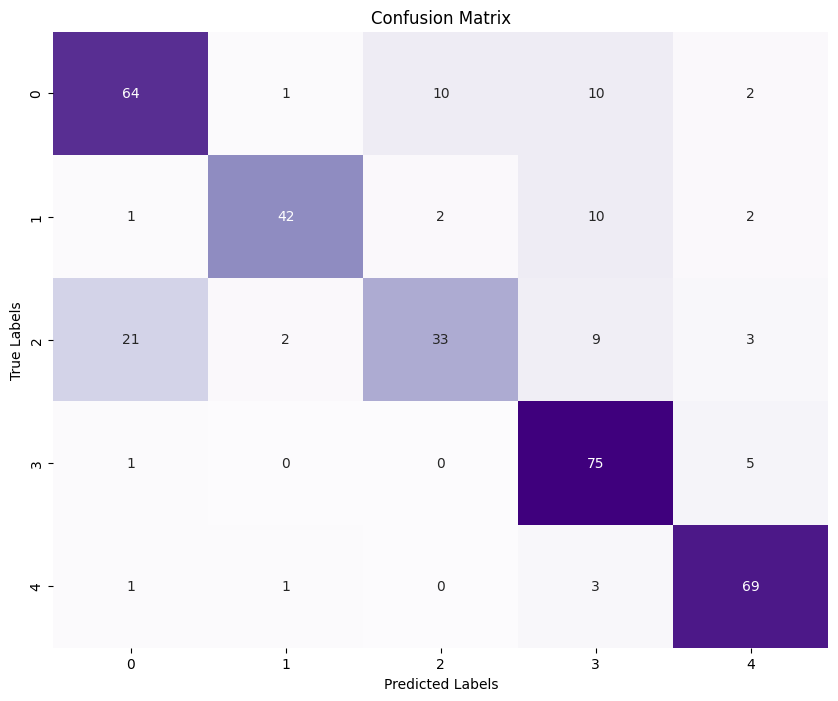

In [ ]:
y_pred = loaded_model.predict(X_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Now you can compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("CM-withoutAUG.png")
files.download("CM-withoutAUG.png")
plt.show()

# Visualizing results with GradCAM

GradCAM is an algorithm that uses the gradient of the predictions of a CNN with respect to the feature map produced by its last convolutional layer to produce a heatmap that highlights the most influential parts of the image for the network.

We can use it to explore predictions done by the network in order to understand if it's focusing in the correct part of the images.

In [ ]:
# Load the model from Google Drive
model_load_path = 'gdrive/My Drive/Colab Notebooks/flower_classification_AUG_model.h5'
loaded_model_aug = tf.keras.models.load_model(model_load_path)

In [ ]:
model_aug.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 24, 24, 32)       

## Finding missed predictions
We identify which samples the model got wrong on the test set

In [ ]:
missed_predictions_indices = np.where(y_pred_classes_aug != y_test)[0]

In [ ]:
print("Wrong prediction indices:", missed_predictions_indices)

Wrong prediction indices: [  0   6   8  16  26  32  45  46  50  55  56  59  64  71  77  78  81  87
 101 118 128 129 130 135 137 143 144 145 148 149 152 157 166 177 185 187
 191 200 201 202 203 204 210 211 217 221 226 246 249 250 257 265 272 277
 278 280 281 283 287 302 305 306 307 318 328 330 332 336 340 341 342 344
 346 347 355 356 359 360]


## GradCAM

In [ ]:
last_conv_layer_name = "conv2d_7"  #look at model.summary if mismatched
img_size=(224,224)

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
model_aug.layers[-1].activation = None

### The good

Let's look first at some samples it got right, one per class, with one of the difficult images (image 200)

In [ ]:
idx1=1
testimage1 = X_test[idx1]
testimage1 = testimage1[np.newaxis,:,:]
idx2 = 200
testimage2 = X_test[idx2]
testimage2 = testimage2[np.newaxis,:,:]
idx3 = 155
testimage3 = X_test[idx3]
testimage3 = testimage3[np.newaxis,:,:]
idx4 = 303
testimage4 = X_test[idx4]
testimage4 = testimage4[np.newaxis,:,:]
idx5 = 10
testimage5 = X_test[idx5]
testimage5 = testimage5[np.newaxis,:,:]

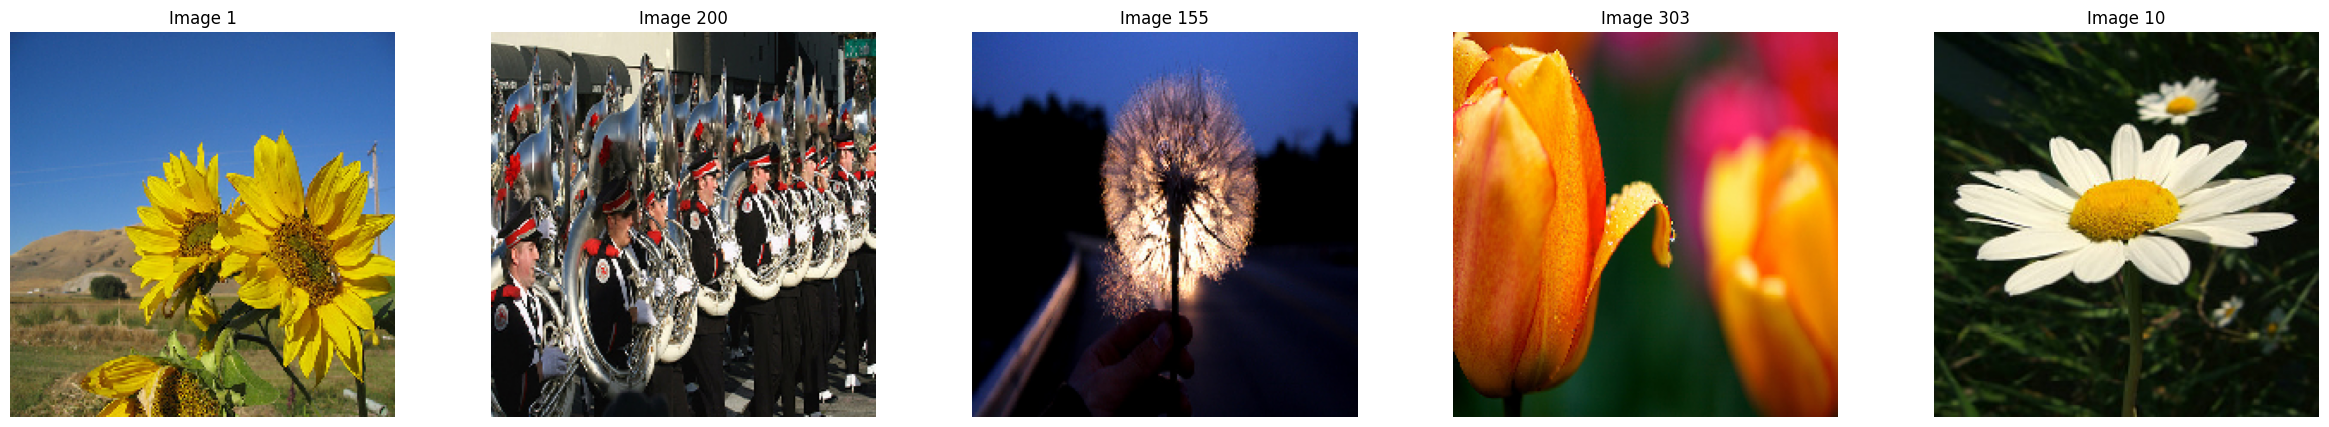

In [ ]:
#plt.imshow((X_test[idx]*255).astype("uint8"))

fig, axs = plt.subplots(1, 5,
                        figsize=(30, 5)
)


axs[0].imshow((X_test[idx1] * 255).astype("uint8"))
axs[0].set_title(f"Image {idx1}")
axs[0].axis('off')


axs[1].imshow((X_test[idx2] * 255).astype("uint8"))
axs[1].set_title(f"Image {idx2}")
axs[1].axis('off')

axs[2].imshow((X_test[idx3] * 255).astype("uint8"))
axs[2].set_title(f"Image {idx3}")
axs[2].axis('off')

axs[3].imshow((X_test[idx4] * 255).astype("uint8"))
axs[3].set_title(f"Image {idx4}")
axs[3].axis('off')

axs[4].imshow((X_test[idx5] * 255).astype("uint8"))
axs[4].set_title(f"Image {idx5}")
axs[4].axis('off')

# Show the figure
plt.show()

In [ ]:
heatmap1 = make_gradcam_heatmap(testimage1, model_aug, last_conv_layer_name)
heatmap2 = make_gradcam_heatmap(testimage2, model_aug, last_conv_layer_name)
heatmap3 = make_gradcam_heatmap(testimage3, model_aug, last_conv_layer_name)
heatmap4 = make_gradcam_heatmap(testimage4, model_aug, last_conv_layer_name)
heatmap5 = make_gradcam_heatmap(testimage5, model_aug, last_conv_layer_name)

We show one raw heatmap for illustration purposes, then we create a superimposed headmap representation for each of the five samples we displayed earlier

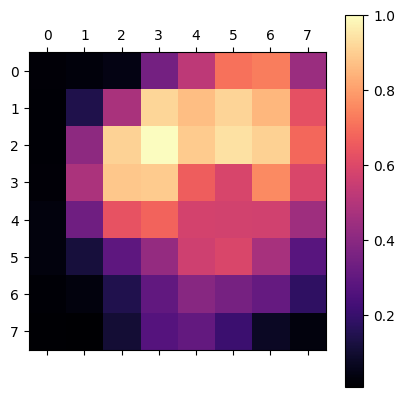

In [ ]:
plt.matshow(heatmap1, cmap="magma")
plt.colorbar()
plt.show()

In [ ]:
import matplotlib as mpl
def compute_gradcam(img, heatmap, alpha=0.5):


    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255*heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[1]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = superimposed_img[0]
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    return superimposed_img





In [ ]:
super_img1 = compute_gradcam(testimage1*255, heatmap1, alpha=0.8)
super_img2 = compute_gradcam(testimage2*255, heatmap2, alpha=0.8)
super_img3 = compute_gradcam(testimage3*255, heatmap3, alpha=0.8)
super_img4 = compute_gradcam(testimage4*255, heatmap4, alpha=0.8)
super_img5 = compute_gradcam(testimage5*255, heatmap5, alpha=0.8)

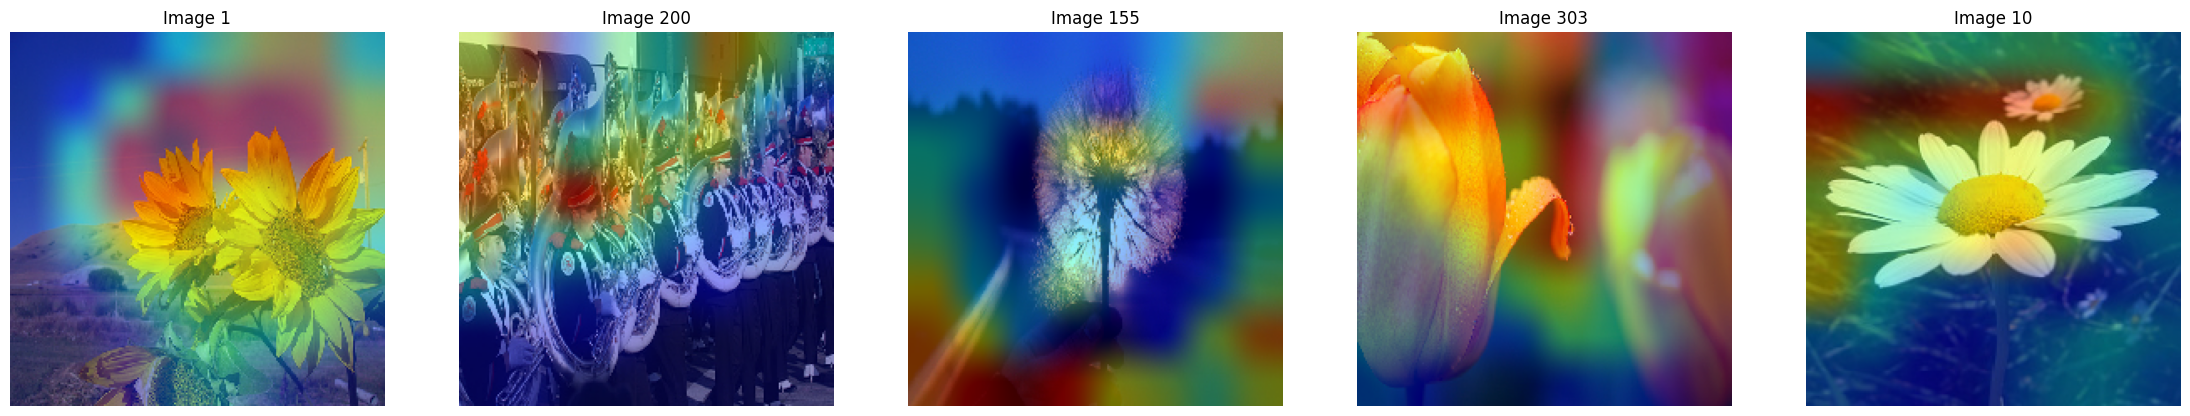

In [ ]:
fig, axs = plt.subplots(1, 5,
                        figsize=(28, 5)
)


axs[0].imshow(super_img1)
axs[0].set_title(f"Image {idx1}")
axs[0].axis('off')


axs[1].imshow(super_img2)
axs[1].set_title(f"Image {idx2}")
axs[1].axis('off')

axs[2].imshow(super_img3)
axs[2].set_title(f"Image {idx3}")
axs[2].axis('off')

axs[3].imshow(super_img4)
axs[3].set_title(f"Image {idx4}")
axs[3].axis('off')

axs[4].imshow(super_img5)
axs[4].set_title(f"Image {idx5}")
axs[4].axis('off')

# Show the figure
plt.show()

These visualizations are all interesting in different ways:
- 1: we can see a focus on the whole flower as expected, maybe with a deeper focus on the petal area
- 200: we can see the focus on the deeply red areas, some of which are the flowers on the band jackets, some instead are the red bands on the hats. This is clearly an image that could have confused the network if it had been in the train set, moreover, it is likely to have been predicted correctly only because of the distinct prevalnce of the red colour in samples of roses
- 155: the network focused on the visible hand for this prediction, leading us to think that there might be a strong prevalence of "dandelions in hand" samples in the dataset, thus a more diverse dataset on this regard could lead to better generalization performances
- 303: once again we see a focus on petal tips and the flower area in general. The underside of the flower is less of the focus, possibly because a scarcity of "full flowers/flowers from underneath" images in the dataset and a greater availability of "flowers form above/underside hidden (ex bouquets)" images
- 10: we see a focus on empty background areas, this could point to a prevalence of "green grass" backgrounds in the daisy class that could be solved with a dataset expansion

### The bad

Now let's look at samples it got wrong to understand possible biases or other improvements we could make

In [ ]:


idx1=0
testimage1 = X_test[idx1]
testimage1 = testimage1[np.newaxis,:,:]
idx2 = 6
testimage2 = X_test[idx2]
testimage2 = testimage2[np.newaxis,:,:]
idx3 = 210
testimage3 = X_test[idx3]
testimage3 = testimage3[np.newaxis,:,:]
idx4 = 341
testimage4 = X_test[idx4]
testimage4 = testimage4[np.newaxis,:,:]
idx5 = 360
testimage5 = X_test[idx5]
testimage5 = testimage5[np.newaxis,:,:]

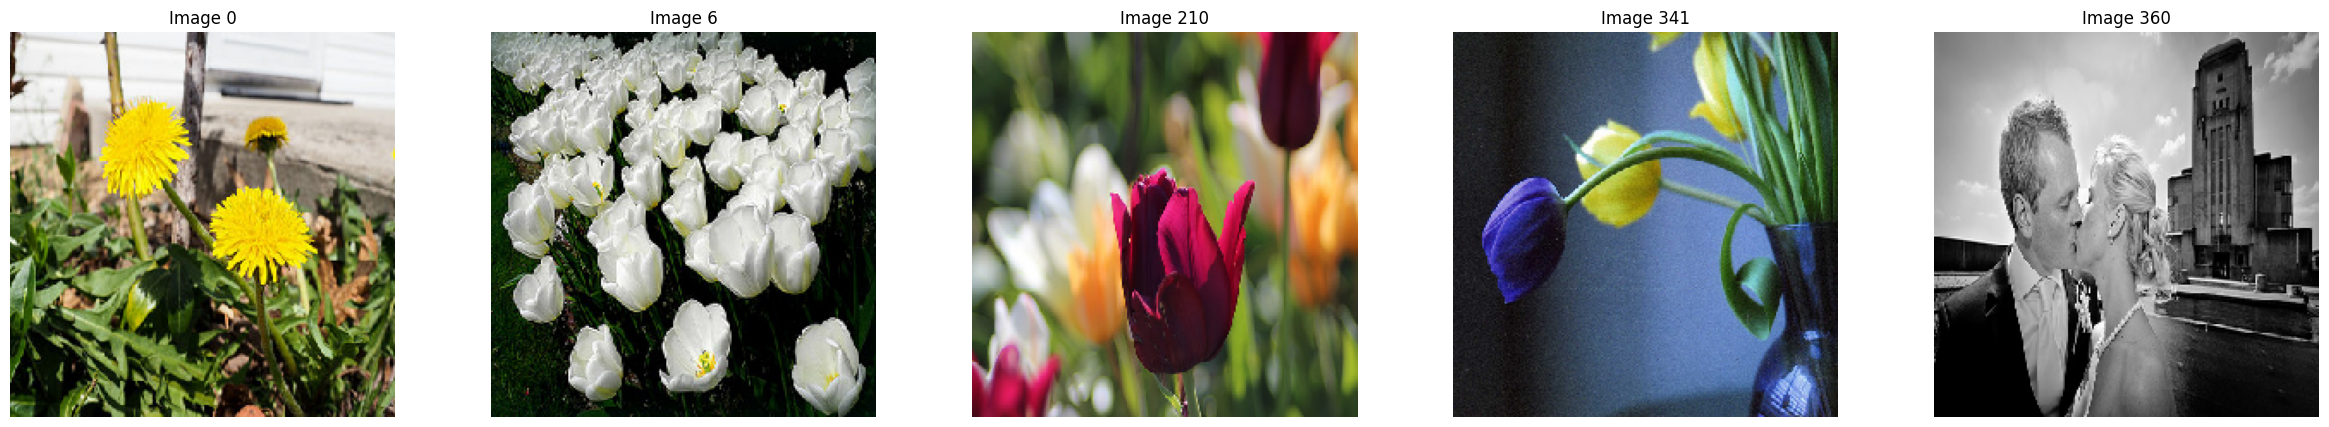

In [ ]:
#plt.imshow((X_test[idx]*255).astype("uint8"))

fig, axs = plt.subplots(1, 5,
                        figsize=(30, 5)
)


axs[0].imshow((X_test[idx1] * 255).astype("uint8"))
axs[0].set_title(f"Image {idx1}")
axs[0].axis('off')


axs[1].imshow((X_test[idx2] * 255).astype("uint8"))
axs[1].set_title(f"Image {idx2}")
axs[1].axis('off')

axs[2].imshow((X_test[idx3] * 255).astype("uint8"))
axs[2].set_title(f"Image {idx3}")
axs[2].axis('off')

axs[3].imshow((X_test[idx4] * 255).astype("uint8"))
axs[3].set_title(f"Image {idx4}")
axs[3].axis('off')

axs[4].imshow((X_test[idx5] * 255).astype("uint8"))
axs[4].set_title(f"Image {idx5}")
axs[4].axis('off')

# Show the figure
plt.show()

In [ ]:
heatmap1 = make_gradcam_heatmap(testimage1, model_aug, last_conv_layer_name)
heatmap2 = make_gradcam_heatmap(testimage2, model_aug, last_conv_layer_name)
heatmap3 = make_gradcam_heatmap(testimage3, model_aug, last_conv_layer_name)
heatmap4 = make_gradcam_heatmap(testimage4, model_aug, last_conv_layer_name)
heatmap5 = make_gradcam_heatmap(testimage5, model_aug, last_conv_layer_name)

In [ ]:
super_img1 = compute_gradcam(testimage1*255, heatmap1, alpha=0.8)
super_img2 = compute_gradcam(testimage2*255, heatmap2, alpha=0.8)
super_img3 = compute_gradcam(testimage3*255, heatmap3, alpha=0.8)
super_img4 = compute_gradcam(testimage4*255, heatmap4, alpha=0.8)
super_img5 = compute_gradcam(testimage5*255, heatmap5, alpha=0.8)

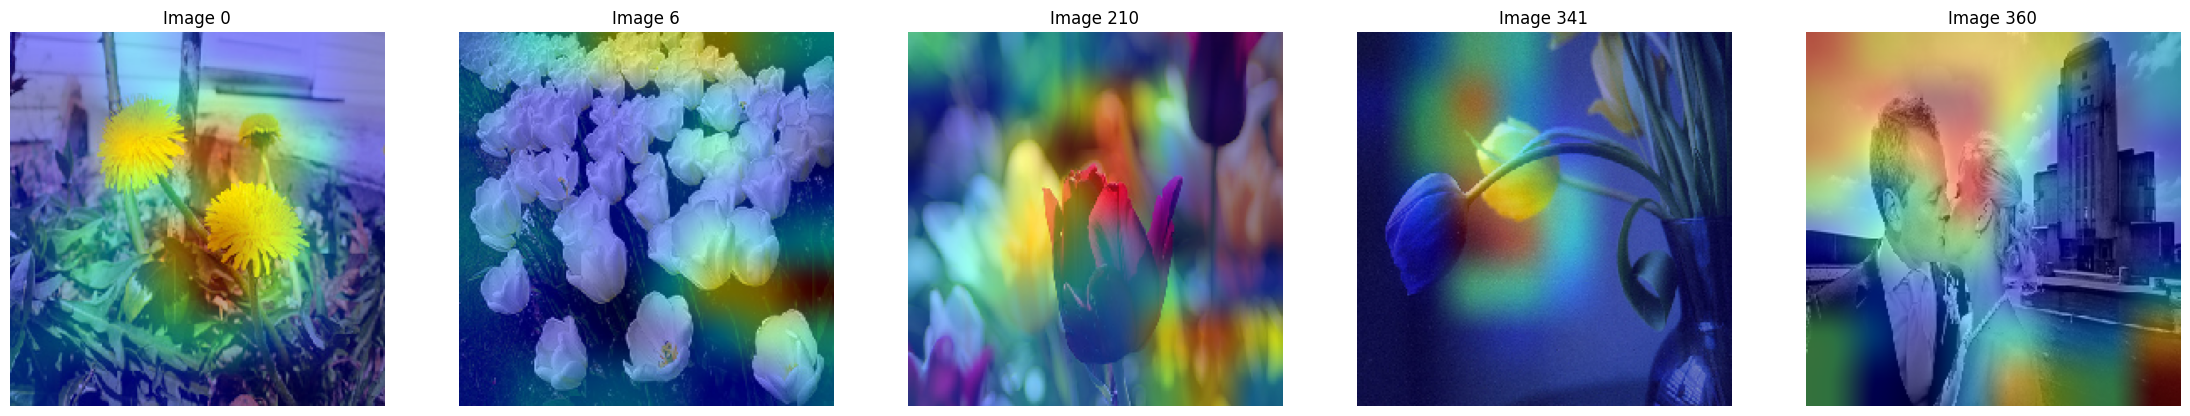

In [ ]:
fig, axs = plt.subplots(1, 5,
                        figsize=(28, 5)
)


axs[0].imshow(super_img1)
axs[0].set_title(f"Image {idx1}")
axs[0].axis('off')


axs[1].imshow(super_img2)
axs[1].set_title(f"Image {idx2}")
axs[1].axis('off')

axs[2].imshow(super_img3)
axs[2].set_title(f"Image {idx3}")
axs[2].axis('off')

axs[3].imshow(super_img4)
axs[3].set_title(f"Image {idx4}")
axs[3].axis('off')

axs[4].imshow(super_img5)
axs[4].set_title(f"Image {idx5}")
axs[4].axis('off')

# Show the figure
plt.show()

What can we see here?
- 0: flower dandelions seem to have been learned as sunflowers, which makes sense for the colour similarity in their flower stage. Possibly, the network struggled to learn flower shape of dandelions because of the hand bias we saw earlier but also it could be because of the presence of both flower and seed stage photos mixed together (seed stage is the "blow on the flower stage")
- 6: we can see some confusion of the network in this case, possibly because of the amount of flowers in the picture all close together. The predicted class for this image was rose, which is a flower that can be the same colour and is also likely to appear in big bouquets, which could explain why flowers bunched together gives that result.
-  210-341: the network here is just wrong, focusing predicting rose for 210 and sunflower for 341. We can see colour is probably a strong factor in the network choices as the activations would suggest.
-360: this image could be considered noise in the dataset, the flower is barely visible on the guy's jacket and the network clearly doesn't recognize it and focuses on random elements of the background to make his prediction. The presence of this picture could be a good indicator that the dataset itself needs some cleaning

### The ugly

more examples of dataset noise and network errors

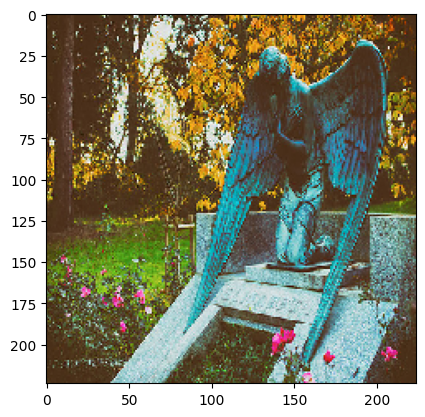

In [ ]:
# Wrong predictions: 0   6   8  16  26  32  45  46  50  55  56  59  64  71  77  78  81  87 101 118 128 129 130 135 137 143 144 145 148 149 152 157 166 177 185 187
# 191 200 201 202 203 204 210 211 217 221 226 246 249 250 257 265 272 277 278 280 281 283 287 302 305 306 307 318 328 330 332 336 340 341 342 344 346 347 355 356 359 360
idx1=55
testimage1 = X_test[idx1]
testimage1 = testimage1[np.newaxis,:,:]
plt.imshow((X_test[idx1] * 255).astype("uint8"))

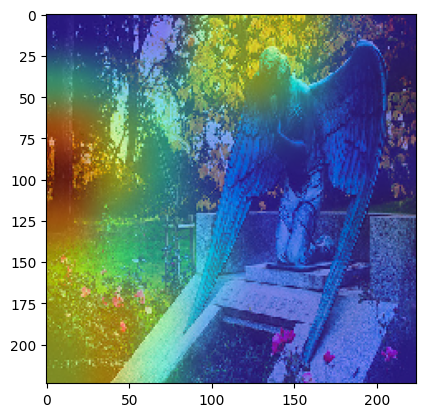

In [ ]:
heatmap1 = make_gradcam_heatmap(testimage1, model_aug, last_conv_layer_name)
super_img1 = compute_gradcam(testimage1*255, heatmap1, alpha=0.8)
plt.imshow(super_img1)

once again, flowers barely visible at processing resolution, network can't find them

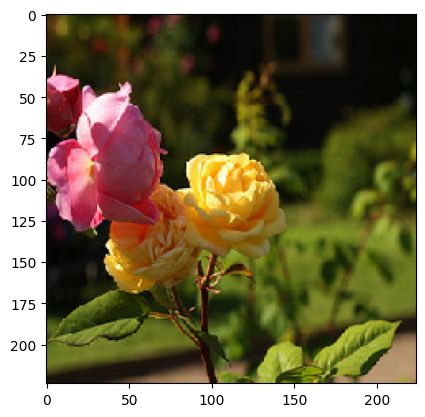

In [ ]:
# Wrong predictions: 0   6   8  16  26  32  45  46  50  55  56  59  64  71  77  78  81  87 101 118 128 129 130 135 137 143 144 145 148 149 152 157 166 177 185 187
# 191 200 201 202 203 204 210 211 217 221 226 246 249 250 257 265 272 277 278 280 281 283 287 302 305 306 307 318 328 330 332 336 340 341 342 344 346 347 355 356 359 360
idx1=217
testimage1 = X_test[idx1]
testimage1 = testimage1[np.newaxis,:,:]
plt.imshow((X_test[idx1] * 255).astype("uint8"))

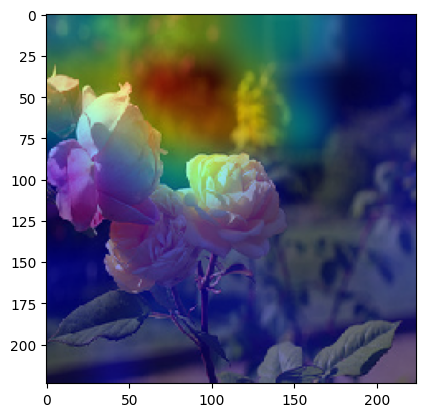

In [ ]:
heatmap1 = make_gradcam_heatmap(testimage1, model_aug, last_conv_layer_name)
super_img1 = compute_gradcam(testimage1*255, heatmap1, alpha=0.8)
plt.imshow(super_img1)

predicted class: tulip, possible bias towards green background when discriminating tulip vs roses

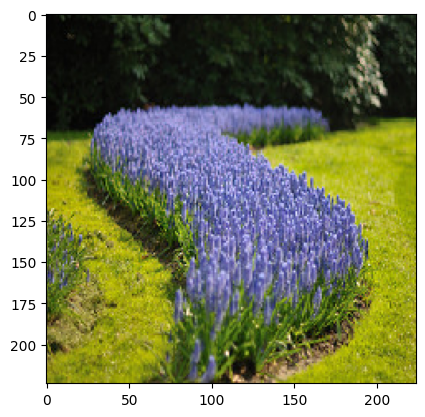

In [ ]:
# Wrong predictions: 0   6   8  16  26  32  45  46  50  55  56  59  64  71  77  78  81  87 101 118 128 129 130 135 137 143 144 145 148 149 152 157 166 177 185 187
# 191 200 201 202 203 204 210 211 217 221 226 246 249 250 257 265 272 277 278 280 281 283 287 302 305 306 307 318 328 330 332 336 340 341 342 344 346 347 355 356 359 360
idx1=185
testimage1 = X_test[idx1]
testimage1 = testimage1[np.newaxis,:,:]
plt.imshow((X_test[idx1] * 255).astype("uint8"))

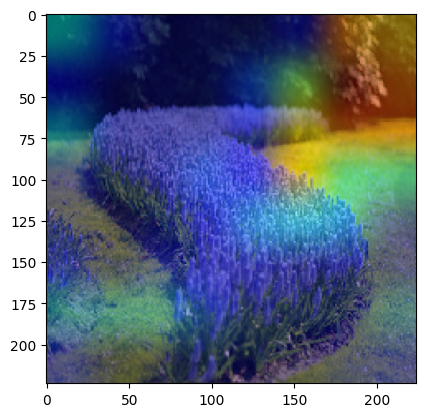

In [ ]:
heatmap1 = make_gradcam_heatmap(testimage1, model_aug, last_conv_layer_name)
super_img1 = compute_gradcam(testimage1*255, heatmap1, alpha=0.8)
plt.imshow(super_img1)

once again, many flowers at low resolution are not distinguishable and the network doesn't find them. Firthermore, this is lavander not tulips and the dataset contains 2 of these image (one slightly rotated and zoomed)